In [1]:
#import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import io
import os

In [3]:
#we load our data by giving path as well as max. no of samples
def load_data(path , num_samples=10000):
    #open the txt file split by space
    with open(path , 'r' , encoding ='utf-8') as f:
        lines = f.read().split('\n')
    input_texts = []
    target_texts = []
    #separately store input and target text
    for line in lines[:num_samples]:
        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue
        #now here the given dataset is french to english but i want eng to french trans so careful with the order
        eng , fra = parts[0] , parts[1]
        #add start and end for decoder
        target_text = "<start> " + fra + " <end>"
        input_texts.append(eng)
        target_texts.append(target_text)
        
    return input_texts, target_texts

input_texts, target_texts = load_data('fra.txt')

In [5]:
def preprocess_text(sentences):
    #convert in lowercase
    sentences =  [s.lower() for s in sentences]
    #remove everything except letters , digits , white spaces , and <>(remember the <start>)
    #dont forget ^ this its the negation symbol i forgot and spend 30 minutes looking for bug
    sentences = [re.sub(r"[^a-zA-Z0-9<>\s]", "", s) for s in sentences]
    return sentences
input_texts = preprocess_text(input_texts)
target_texts = preprocess_text(target_texts)

In [7]:
# Tokenize output
#as we have already cleaned the text filter is off('' - do not remove anything)
input_tokenizer = Tokenizer(filters = '')
#go through all sentences and build a word-index vocab
input_tokenizer.fit_on_texts(input_texts)
#use the vocab and replce each word with its integer ID
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
#extract the word to index vocab or dict. for future uses
input_word_index = input_tokenizer.word_index
#find the max.sequence length
max_input_len = max(len(seq) for seq in input_sequences)
#pad with 0 if length is lower than max length
encoder_input_data = pad_sequences(input_sequences , maxlen = max_input_len ,padding='post')



In [9]:
# Tokenize output
#No comments as everything is same as above
target_tokenizer = Tokenizer(filters='')
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_word_index = target_tokenizer.word_index
max_target_len = max(len(seq) for seq in target_sequences)
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_len,padding='post')

In [11]:
## Creating decoder targets

#create a numpy array of same shape as decoder_input_data
decoder_target_data = np.zeros_like(decoder_input_data)
#now we take all the columns from 1 to end from decoder_input_data and fill it in decoder_target_data from 0 to end - 1 
#so basically we shifted left
decoder_target_data[:,:-1] = decoder_input_data[:, 1:]
#well this is actually not necessary but i still did that just to be safe , it does nothing but make sure last value is zero
decoder_target_data[:, -1] = 0

In [13]:
#embedding dimensions
embedding_dim = 256 
#LSTM hidden units
lstm_units = 512
#vocab size , +1 for padding token
input_vocab_size = len(input_word_index)+1
target_vocab_size = len(target_word_index)+1

In [15]:
#Encoder Model
#encoder inputs
encoder_inputs = Input(shape = (None , ))
#embedding layer take encoder inputs of size vocab size as defined above and embed them and convert into dimensions of embedding_dim
enc_emb = Embedding(input_vocab_size ,embedding_dim , mask_zero = True)(encoder_inputs)
#a LSTM layer with hidden units = lstm_units and we want final hidden state as well as cell state so return_state is true
encoder_outputs , state_h , state_c = LSTM(lstm_units, return_state = True)(enc_emb)
#store the stats
encoder_states = [state_h , state_c]

In [16]:
#Decoder Model
#No change so no comment in next two lines
decoder_inputs = Input(shape = (None , ))
decoder_emb_layer = Embedding(target_vocab_size, embedding_dim, mask_zero=True, name='dec_emb')
dec_emb = decoder_emb_layer(decoder_inputs)
#just defining the LSTM layer and in addition to states we want output at each state/time step so return_sequence = True
decoder_lstm = LSTM(lstm_units,return_sequences = True, return_state = True)
#get the outputs by giving dec_emb as input and passing encoder's states as initial states
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)
#create a dense layer as softmax as activation
decoder_dense = Dense(target_vocab_size, activation = 'softmax')
#pass previous outputs as inputs in dense layer and get new outputs 
decoder_outputs =  decoder_dense(decoder_outputs)


In [19]:
#Training Model
#combined model with teacher forcing
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)
#we are using 'sparse_categorical_crossentropy' cause we didnt one-hot encode targets
model.compile(optimizer = 'adam' , loss ='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [21]:
#lets check our model 
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, None, 256)         │         517,632 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, None)              │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dec_emb (Embedding)           │ (None, None, 256)         │       1,168,896 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 512), (None,      │       1,574,912 │ embedding[0][0],           │
│                               │ 512), (None, 512)]        │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, None, 512),       │       1,574,912 │ dec_emb[0][0], lstm[0][1], │
│                               │ (None, 512), (None, 512)] │                 │ lstm[0][2]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 4566)        │       2,342,358 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 7,178,710 (27.38 MB)

 Trainable params: 7,178,710 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Train the Model
#... maens all the dimensions
history = model.fit([encoder_input_data,decoder_input_data], decoder_target_data[...,np.newaxis], 
                    batch_size = 64, epochs = 30,
                   validation_split = 0.2)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 632ms/step - accuracy: 0.3771 - loss: 5.6099 - val_accuracy: 0.1961 - val_loss: 3.9329
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 623ms/step - accuracy: 0.1971 - loss: 3.3951 - val_accuracy: 0.2211 - val_loss: 3.6113
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 621ms/step - accuracy: 0.2198 - loss: 2.8770 - val_accuracy: 0.2375 - val_loss: 3.4090
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 812ms/step - accuracy: 0.2346 - loss: 2.4880 - val_accuracy: 0.2525 - val_loss: 3.2880
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 657ms/step - accuracy: 0.2487 - loss: 2.1280 - val_accuracy: 0.2567 - val_loss: 3.2321
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 650ms/step - accuracy: 0.2586 - loss: 1.8376 - val_accuracy: 0.2614 - val_loss: 3.2246
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 651ms/step - accuracy: 0.2691 - loss: 1.5801 - val_accuracy: 0.2654 - val_loss: 3.2137
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 652ms/step - accuracy: 0.2807 - loss: 

In [26]:
# Inference encoder model: just takes input and gives out hidden states
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Reuse the embedding and LSTM
dec_emb2 = decoder_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs
)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model for inference
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [28]:
reverse_target_index = {i: word for word, i in target_tokenizer.word_index.items()}
reverse_target_index[0] = ''  # For padding

target_index_word = target_tokenizer.word_index
start_token = target_index_word['<start>']
end_token = target_index_word['<end>']

def decode_sequence(input_seq):
    # Encode the input
    states_value = encoder_model.predict(input_seq)

    # Prepare start token as first input to decoder
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample the best word
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_index.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence) > max_target_len:
            stop_condition = True
        else:
            decoded_sentence.append(sampled_word)

        # Update decoder input for next time step
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return ' '.join(decoded_sentence)

In [56]:
#lets check
def predict_sample(index):
    input_seq = encoder_input_data[index:index+1]
    decoded = decode_sequence(input_seq)
    print("Input:", input_texts[index])
    print("Target:", target_texts[index])
    print("Predicted:", decoded)


predict_sample(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Input: go
Target: <start> va  <end>
Predicted: marche


In [60]:
# lets translate and check 5 sentences
def predict_samples(start_index, num_samples=5):
    for i in range(start_index, start_index + num_samples):
        input_seq = encoder_input_data[i:i+1]
        decoded = decode_sequence(input_seq)
        print(f"Sample {i}:")
        print("Input: ", input_texts[i])
        print("Target:", target_texts[i])
        print("Predicted:", decoded)
        print("="*50)

# predict 5 samples from index 0
predict_samples(0, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Sample 0:
Input:  go
Target: <start> va  <end>
Predicted: marche
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Sample 1:
Input:  go
Target: <start> marche <end>
Predicted: marche
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Sample 2:
Input:  go
Target: <start> en route  <end>
Predicted: marche
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Sample 3:
Input:  go
Target: <start> bouge  <end>
Predicted: marche
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Sample 4:
Input:  hi
Target: <start> salut  <end>
Predicted: salut


In [42]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothie = SmoothingFunction().method4  

In [34]:
def evaluate_bleu_score(num_samples=100):
    total_score = 0.0
    individual_scores = []

    for i in range(num_samples):
        input_seq = encoder_input_data[i:i+1]
        decoded_sentence = decode_sequence(input_seq).strip().split()
        reference_sentence = target_texts[i].replace('<start>', '').replace('<end>', '').strip().split()

        score = sentence_bleu([reference_sentence], decoded_sentence, smoothing_function=smoothie)
        individual_scores.append(score)
        total_score += score

    avg_bleu = total_score / num_samples
    print(f"\nAverage BLEU score on {num_samples} samples: {avg_bleu:.4f}")
    return avg_bleu, individual_scores

In [36]:
avg_bleu, scores = evaluate_bleu_score(100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104m

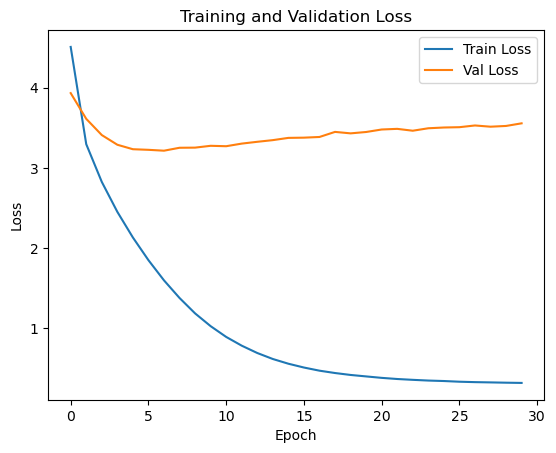

In [37]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

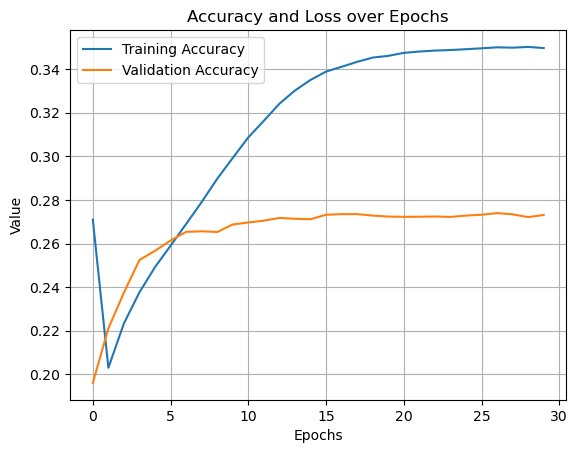

In [38]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy and Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [62]:
#bleu score of 0.3475 indicates that the model has learned some structure and semantics. 
#It produces reasonable, though imperfect, translations. This is respectable for a baseline system.

In [64]:
#i have tried multiple ways like increasing or decreasing epochs , masking the padding 0 but model won't improve much
#this means either model is just too basic to produce better results or furthure data engineering is needed